In [1]:
import json_tricks
answer = {}

# Gradient descent:

Here is a theory:
- Gradient of the loss function over the weights $\nabla_{\mathbf x} L$ points to the direction of the fastest ascend.
- Thus, we need to perfrom steps in the opposite direction
- Here is the Gradient Descent Algorithm:
$\mathbf w^{t+1} = \mathbf w^{t} - \alpha \nabla_{\mathbf w} L$

# Finding gradient with Torch

Torch knows, how to calculate derivative of some value over all the tensors that were used to produce it.
To do so, we have to calculate this value (usually it is loss function), and after that we have to call its `backward` method.

Here is how it is done:
```python
x = torch.tensor(10, requires_grad=True)
y = torch.tensor(5, requires_grad=True)
loss = x + y
loss.backward()

print(x.grad)
print(y.grad)
```

The output should be 1 and 1 because if $L = x + y$, then $\partial_x L = 1$ and $\partial_y L = 1$

`requires_grad` parameter indicates that for this value it is necessary to calculate gradient (that probably is obvious, but still important).

Note that before you perform backpropagation, the gradient is equal to `None` indicating that it is not initialized and cannot be used.

In [27]:
import torch

x = torch.tensor(10., requires_grad=True)
y = torch.tensor(5., requires_grad=True)

loss = x + y

loss.backward()

answer = {}
answer['x_grad'] = x.grad.item()
answer['y_grad'] = y.grad.item()


AttributeError: 'Tensor' object has no attribute 'gracd'

In the next task we will calculate something slightly more sophisticated. We will calculate gradient for the value

$f(X) = 10\cdot\sum\limits_{i, j}x_{ij}^2$

Our task is to find

$\partial_X f(X)$

Theoretically it is equal to:

$\partial_{x_{kl}} f(X) = \Big( 10\cdot\sum\limits_{i, j}x_{ij}^2\Big)_{x_{kl}}' = 10 \cdot\Big(\sum\limits_{i, j}x_{ij}^2\Big)_{x_{kl}}' $

$ \quad = 10 \cdot\sum\limits_{i, j}\Big(x_{ij}^2\Big)_{x_{kl}}' $

$ \quad = 10 \cdot\sum\limits_{i, j}2 x_{ij} \big(x_{ij}\big)_{x_{kl}}' $


$ \quad = 10 \cdot 2 x_{kl} \cdot 1 = 20 x_{kl} $

Hence, the theoretical derivative is:

$f(X) = 10\cdot\sum\limits_{i, j}x_{ij}^2$

$\partial_X f(X) = 20 X $

Let us try to calculate the result using Torch:

In [18]:
import torch

X = torch.tensor(
    [[1.,  2.,  3.,  4.],
     [5.,  6.,  7.,  8.],
     [9., 10., 11., 12.]], requires_grad=True)

## YOUR CODE HERE ##
function = 10 * (X ** 2).sum()
function.backward()

# convert these to normal integers
answer['X_grad'] = X.grad.clone().numpy()
print(X.grad, '<- gradient')

tensor([[ 20.,  40.,  60.,  80.],
        [100., 120., 140., 160.],
        [180., 200., 220., 240.]]) <- gradient


# Function order

In Torch you may visualize, in which order the functions are there in the graph, example is below

In [4]:
print(function.grad_fn)
print(function.grad_fn.next_functions[0][0])
print(function.grad_fn.next_functions[0][0].next_functions[0][0])
print(function.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])

# Some visualization functions

This function will be useful to see the contours of the function

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def show_contours(objective,
                  x_lims=[-10.0, 10.0], 
                  y_lims=[-10.0, 10.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

# Programming the Gradient Descent

We will start with optimizing a simple function:

$f(x, y) = 10 (x^2 + y^2)$

It is a good function to start with as it has minimum at point $(0, 0)$. We should see convergence towards that point

## The Task
- code the function `function_parabola` that calculates the objective function.
- code the gradient descent step with $\alpha = 0.001$. For that:
    - calculate the objective function value
    - perform backporpagation
    - perform a correct update of `X.data`
    - zero the gradient of `X` using `X.grad.zero_()`

In [6]:
import torch

x = torch.tensor([8., 8.], requires_grad=True)

var_history = []
fn_history = []

def function_parabola(X):
    res = 0
    ## YOUR CODE HERE ##
    res = 10 * (X ** 2).sum()
    return res

def make_gradient_step(function, X):
    alpha = 0.001
    value = function(X)
    value.backward()

    var_snapshot = X.detach().clone().numpy()
    fn_value = value.item()

    with torch.no_grad():
        X.copy_(X - alpha * X.grad)

    X.grad.zero_()
    # var_history.append(X.data.clone().numpy())
    # fn_history.append(value.item())

    return var_snapshot, fn_value


for s in range(1000):
    var_history_var, fn_history_var = make_gradient_step(function_parabola, x)
    var_history.append(var_history_var)
    fn_history.append(fn_history_var)


print("Final value:", x)

answer['var_history_1'] = var_history
answer['fn_history_1'] = fn_history



Final value: tensor([1.3464e-08, 1.3464e-08], requires_grad=True)


# Some visualizations

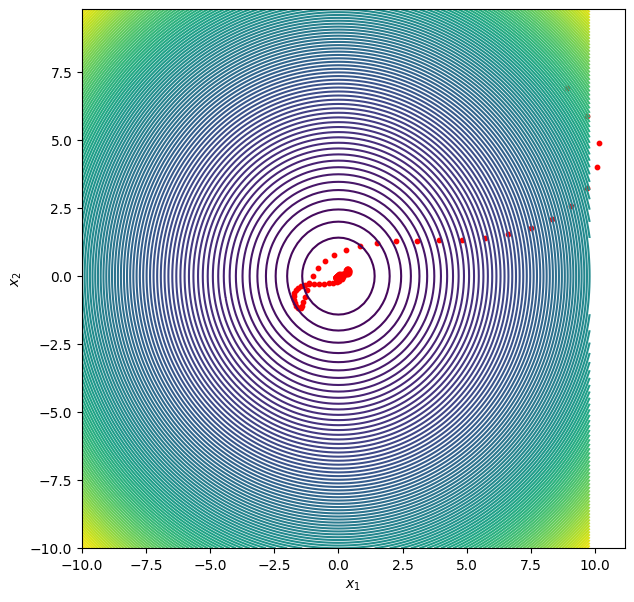

In [19]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

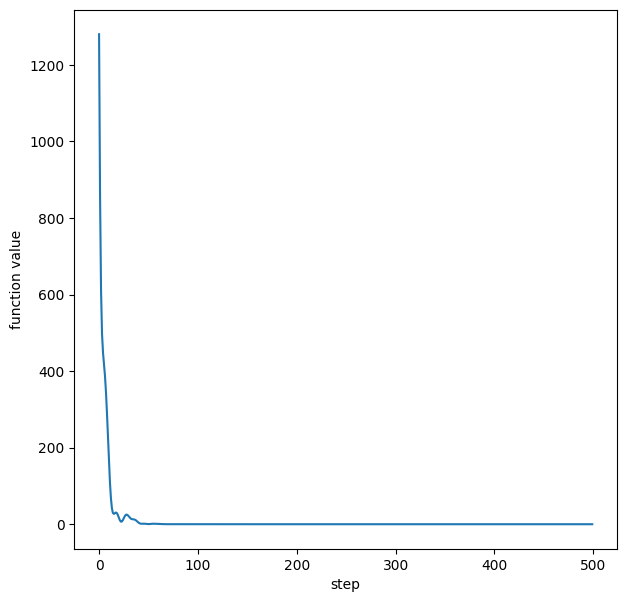

In [20]:
plt.figure(figsize=(7,7))
plt.plot(fn_history);
plt.xlabel('step')
plt.ylabel('function value');

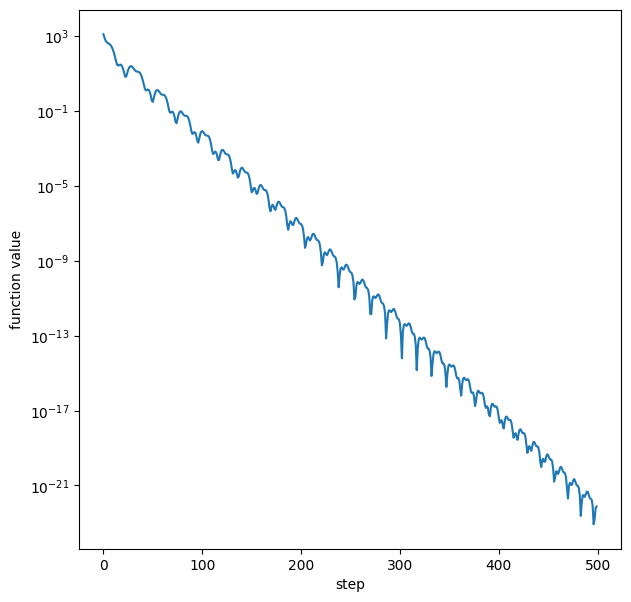

In [21]:
plt.figure(figsize=(7,7))
plt.semilogy(fn_history);
plt.xlabel('step')
plt.ylabel('function value');

# Optimizing a slightly more sophisticated function

Below is another function `function_skewed`. Perform its optimization using the Gradient Descend that you have coded above.

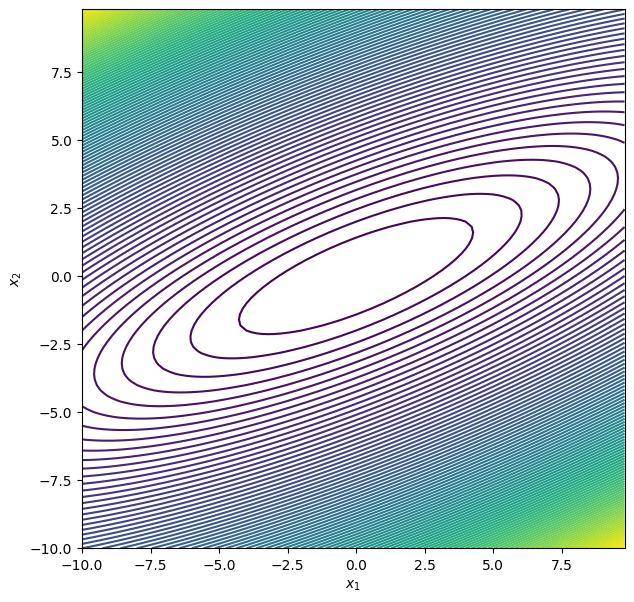

In [22]:

def function_skewed(variable):
    gramma = torch.tensor([[1., -1.], [1., 1.]]) @ torch.tensor([[1.0, 0.0], [0.0, 4.0]])
    res = 10 * (variable.unsqueeze(0) @ (gramma @ variable.unsqueeze(1))).sum()
    return res

def function_skewed_np(variable):
    gramma = np.array([[1, -1], [1, 1]]) @ np.array([[1.0, 0.0], [0.0, 4.0]])
    res = 10 * (variable.transpose(1, 0) @ (gramma @ variable)).sum()
    return res

show_contours(function_skewed_np)

In [ ]:
x = torch.tensor(
    [8., 8.], requires_grad=True)

var_history = []
fn_history = []

for i in range(1000):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_skewed(x).data.cpu().numpy().copy())
    make_gradient_step(function_skewed, x)

answer['var_history_2'] = var_history
answer['fn_history_2'] = fn_history

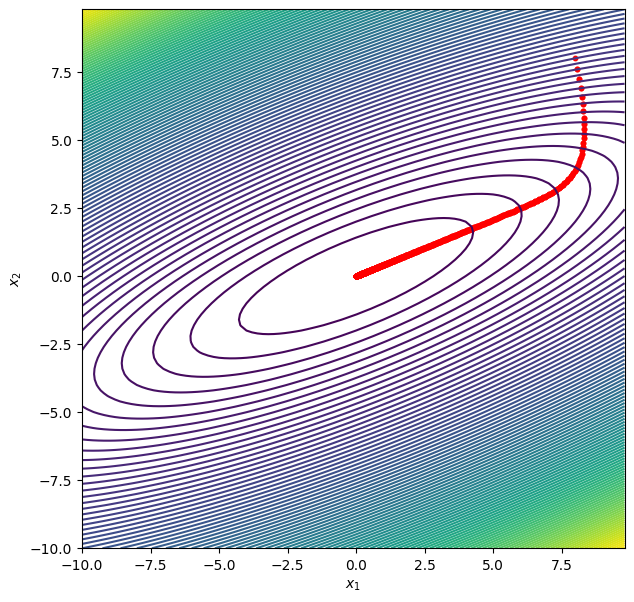

In [24]:
show_contours(function_skewed_np)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

# How to use this

Now you can find minimum of rather sophisticated functions

# Torch Optim

Torch has Optim package that contains a lot of interesting optimizers. The most widely used ones are:
- SGD
- AdamW

We will study the differences between the optimizers a bit later, nevertheless, you can use them both to the functions above

Below your task is to: 
- create an optimizer `SGD` with learning rate 0.001. This optimizer should optimize variable `x`
- optimize the function `function_skewed` with it with the following steps:
    1. zero the optimizer's gradients (in case you do not do that, the gradients will accumulate)
    2. calculate function value
    2. bacpropagate the gradient
    3. make optimization step



In [13]:
x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

## YOUR CODE HERE ##
optimizer = torch.optim.SGD([x], lr=0.001)

for i in range(500):
    ## YOUR CODE HERE ##
    optimizer.zero_grad()
    function_result = function_skewed(x)
    function_result.backward()
    optimizer.step()



    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_result.data.cpu().numpy().copy())

answer['var_history_3'] = var_history
answer['fn_history_3'] = fn_history


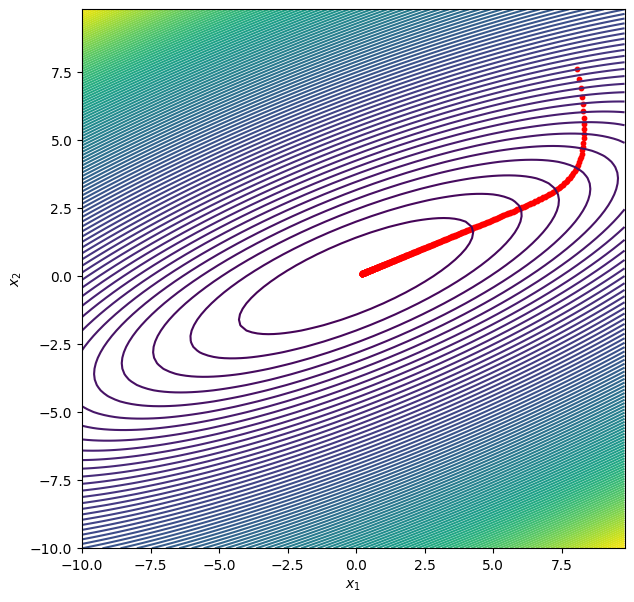

In [14]:
show_contours(function_skewed_np)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

Lastly, here you should create `AdamW` optimizer with learning rate `1`.
Perform the same steps in the optimization cycle

In [15]:
x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

## YOUR CODE HERE ##
optimizer = torch.optim.AdamW([x], lr=1)

for i in range(500):
    ## YOUR CODE HERE ##
    optimizer.zero_grad()
    function_result = function_skewed(x)
    function_result.backward()
    optimizer.step()

    
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_result.data.cpu().numpy().copy())

answer['var_history_4'] = var_history
answer['fn_history_4'] = fn_history


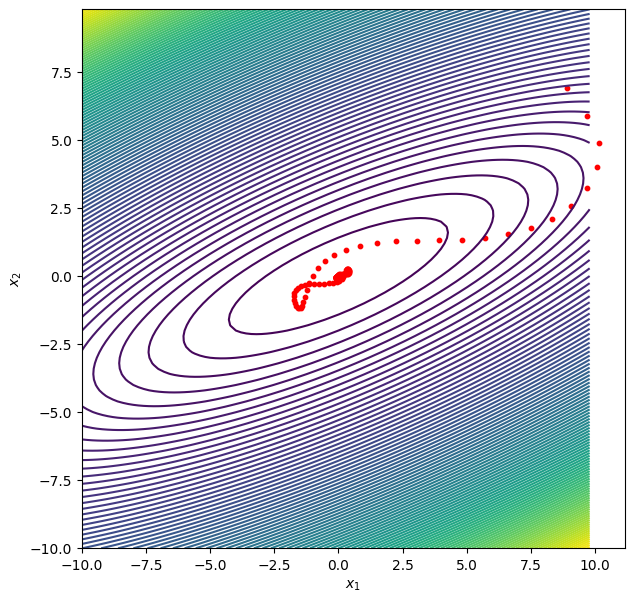

In [16]:
show_contours(function_skewed_np)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

# Other optimizers

There are other optimizers in Torch Optim package, but they are almost never used. 

You even can code your own optimizer if you dare.

Nevertheless, the most widely used optimizer and kind of a default choice for any network is Adam.

# Conclusion

Now you know how to do optimization with Torch package

In [17]:
json_tricks.dump(answer, open('.answer.json', 'w'))

'{"X_grad": {"__ndarray__": [[20.0, 40.0, 60.0, 80.0], [100.0, 120.0, 140.0, 160.0], [180.0, 200.0, 220.0, 240.0]], "dtype": "float32", "shape": [3, 4], "Corder": true}, "var_history_2": [{"__ndarray__": [8.0, 8.0], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.079999923706055, 7.599999904632568], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.079999923706055, 7.599999904632568], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.14639949798584, 7.234399795532227], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.14639949798584, 7.234399795532227], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.2005033493042, 6.9000396728515625], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.2005033493042, 6.9000396728515625], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.243494033813477, 6.594051361083984], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.243494033813477, 6.594051361083984], "dtype": "float32", "shape": [2]}, {"__ndarray__": [8.276445